In [2]:
from app.assistant.card.nodes import _build_choices_from_card_list
import logging
from uuid import uuid4
from pprint import pprint
from typing import Literal
from typing import Annotated, Any


from app.auth.auth_service import AuthService
from langchain_core.messages import HumanMessage, AIMessage
from app.core.config import settings
from app.core.context import RequestContext
from app.entity.api import AuthReqDto, AuthRespDto, AuthUserType
from app.prompt.prompt_service import PromptService
from app.assistant.card.state import CardAgentState
from app.assistant.card.nodes import retrieve_cards, retrieve_renewable_cards
from app.entity import (
    Card,
    ChatRespDto,
    ChatRespAction,
    ChatRespMetadataForCardChoice,
    ChatRespMetadataForChoices,
)

from app.entity.chat_response import ChatRespMetadataForRenewCard

from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from langchain_openai import AzureChatOpenAI
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import END, StateGraph
from langchain_core.tools import tool
from langchain_core.runnables import RunnableConfig
from langgraph.prebuilt import InjectedState

In [2]:
ps = PromptService()

In [3]:
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

load_dotenv()

True

In [3]:
request_context = RequestContext(str(uuid4()))

In [5]:
llm_model = AzureChatOpenAI(azure_deployment=settings.azure_openai_deployment)

In [6]:
state_storage = "../data/renew_card.sqlite"
amemory = AsyncSqliteSaver.from_conn_string(state_storage)

# State

In [7]:
card_agent_state = CardAgentState(
    messages=[],
    responses=[],
    cards=None,
)

# Get cards

In [8]:
async def get_auth_response() -> AuthRespDto:
    auth_req_dto = AuthReqDto(
        username=settings.ebp_test_account_username,
        password=settings.ebp_test_account_password,
        user_type=AuthUserType.RETAIL,
    )
    auth_service = AuthService()
    auth_resp_dto = await auth_service.login(ctx=request_context, req=auth_req_dto)
    return auth_resp_dto

In [10]:
auth_response = await get_auth_response()

2024-09-06 08:39:19.288 | DEBUG    | app.auth.auth_service:_access_token:65 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting token from: https://identity.stg.sdbxaz.azure.backbaseservices.com/auth/realms/customer/protocol/openid-connect/token
2024-09-06 08:39:20.111 | INFO     | app.auth.auth_service:_access_token:77 | c3be4896-1464-400c-bd5c-55fef2069815  - Returning token...
2024-09-06 08:39:20.113 | DEBUG    | app.auth.auth_service:_get_service_agreements:96 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting service agreements from: https://retail.stg.sdbxaz.azure.backbaseservices.com/api/access-control/client-api/v3/accessgroups/user-context/service-agreements
2024-09-06 08:39:20.957 | INFO     | app.auth.auth_service:_get_service_agreements:109 | c3be4896-1464-400c-bd5c-55fef2069815  - Returning service agreement id...
2024-09-06 08:39:20.959 | DEBUG    | app.auth.auth_service:_set_user_context:131 | c3be4896-1464-400c-bd5c-55fef2069815  - Setting user context at: https://retail.s

In [11]:
agent_configurable = {
    "ebp_access_token": auth_response.access_token,
    "ebp_cookie": auth_response.cookie,
    "ebp_edge_domain": auth_response.edge_domain,
    "ctx": request_context,
    "llm_model": llm_model,
    "ps": ps,
}

In [12]:
cards = await retrieve_cards.ainvoke(
    input={"state": card_agent_state},
    config={"configurable": agent_configurable | {"thread_id": str(uuid4())}},
)

2024-09-06 08:39:21.813 | INFO     | app.assistant.card.nodes:get_cards:46 | c3be4896-1464-400c-bd5c-55fef2069815  - Retrieve a list of cards...
2024-09-06 08:39:21.814 | DEBUG    | app.bb_retail.request:list_cards:114 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting list cards...
2024-09-06 08:39:21.815 | DEBUG    | app.bb_retail.request:_make_request:151 | c3be4896-1464-400c-bd5c-55fef2069815  - Making request to https://retail.stg.sdbxaz.azure.backbaseservices.com/api/cards-presentation-service/client-api/v2/cards...
2024-09-06 08:39:23.525 | DEBUG    | app.bb_retail.request:list_cards:119 | c3be4896-1464-400c-bd5c-55fef2069815  - Response from _make_request: [{'id': 'b465eb1e-5cba-4823-981f-acb26ea3b982', 'brand': 'mastercard', 'type': 'Debit', 'status': 'Active', 'lockStatus': 'UNLOCKED', 'replacement': {'status': 'NotUnderReplacement', 'additions': {}}, 'holder': {'name': 'Sara Williams', 'additions': {}}, 'expiryDate': {'year': '2028', 'month': '08', 'additions': {}}, 'currency

In [13]:
for card in cards:
    pprint(card.dict())

{'brand': 'mastercard',
 'card_type': 'Debit',
 'currency': 'USD',
 'expiry_date': '2028-08-31',
 'holder_name': 'Sara Williams',
 'id': 'b465eb1e-5cba-4823-981f-acb26ea3b982',
 'lock_status': 'UNLOCKED',
 'replacement_status': 'NotUnderReplacement',
 'status': 'Active'}
{'brand': 'mastercard',
 'card_type': 'Debit',
 'currency': 'USD',
 'expiry_date': '2028-08-31',
 'holder_name': 'Sara Williams',
 'id': 'd94b0808-f085-4ddd-be66-bd8fe67119a1',
 'lock_status': 'UNLOCKED',
 'replacement_status': 'Replaced',
 'status': 'Cancelled'}


In [14]:
retrieve_cards.get_input_schema().schema()

{'title': 'retrieve_cardsSchema',
 'description': 'Retrieve a list of cards.',
 'type': 'object',
 'properties': {'state': {'$ref': '#/definitions/CardAgentState'}},
 'required': ['state'],
 'definitions': {'ToolCall': {'title': 'ToolCall',
   'type': 'object',
   'properties': {'name': {'title': 'Name', 'type': 'string'},
    'args': {'title': 'Args', 'type': 'object'},
    'id': {'title': 'Id', 'type': 'string'},
    'type': {'title': 'Type', 'enum': ['tool_call'], 'type': 'string'}},
   'required': ['name', 'args', 'id']},
  'InvalidToolCall': {'title': 'InvalidToolCall',
   'type': 'object',
   'properties': {'name': {'title': 'Name', 'type': 'string'},
    'args': {'title': 'Args', 'type': 'string'},
    'id': {'title': 'Id', 'type': 'string'},
    'error': {'title': 'Error', 'type': 'string'},
    'type': {'title': 'Type',
     'enum': ['invalid_tool_call'],
     'type': 'string'}},
   'required': ['name', 'args', 'id', 'error']},
  'UsageMetadata': {'title': 'UsageMetadata',
   

In [15]:
retrieve_cards.tool_call_schema.schema()

{'title': 'retrieve_cards',
 'description': 'Retrieve a list of cards.',
 'type': 'object',
 'properties': {}}

In [16]:
renewable_cards = await retrieve_renewable_cards.arun(
    tool_input={"state": card_agent_state},
    config={"configurable": agent_configurable | {"thread_id": str(uuid4())}},
)

2024-09-06 08:39:25.892 | INFO     | app.assistant.card.nodes:get_cards:46 | c3be4896-1464-400c-bd5c-55fef2069815  - Retrieve a list of cards...
2024-09-06 08:39:25.893 | DEBUG    | app.bb_retail.request:list_cards:114 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting list cards...
2024-09-06 08:39:25.894 | DEBUG    | app.bb_retail.request:_make_request:151 | c3be4896-1464-400c-bd5c-55fef2069815  - Making request to https://retail.stg.sdbxaz.azure.backbaseservices.com/api/cards-presentation-service/client-api/v2/cards...
2024-09-06 08:39:27.444 | DEBUG    | app.bb_retail.request:list_cards:119 | c3be4896-1464-400c-bd5c-55fef2069815  - Response from _make_request: [{'id': 'b465eb1e-5cba-4823-981f-acb26ea3b982', 'brand': 'mastercard', 'type': 'Debit', 'status': 'Active', 'lockStatus': 'UNLOCKED', 'replacement': {'status': 'NotUnderReplacement', 'additions': {}}, 'holder': {'name': 'Sara Williams', 'additions': {}}, 'expiryDate': {'year': '2028', 'month': '08', 'additions': {}}, 'currency

In [17]:
retrieve_renewable_cards.get_input_schema().schema()

{'title': 'retrieve_renewable_cardsSchema',
 'description': 'Retrieve a list of expired or nearly expired cards.',
 'type': 'object',
 'properties': {'state': {'$ref': '#/definitions/CardAgentState'},
  'expired_days': {'title': 'Expired Days',
   'description': 'Number of days before expiry. Input only an integer number without any operator',
   'default': 30,
   'type': 'integer'}},
 'required': ['state'],
 'definitions': {'ToolCall': {'title': 'ToolCall',
   'type': 'object',
   'properties': {'name': {'title': 'Name', 'type': 'string'},
    'args': {'title': 'Args', 'type': 'object'},
    'id': {'title': 'Id', 'type': 'string'},
    'type': {'title': 'Type', 'enum': ['tool_call'], 'type': 'string'}},
   'required': ['name', 'args', 'id']},
  'InvalidToolCall': {'title': 'InvalidToolCall',
   'type': 'object',
   'properties': {'name': {'title': 'Name', 'type': 'string'},
    'args': {'title': 'Args', 'type': 'string'},
    'id': {'title': 'Id', 'type': 'string'},
    'error': {'tit

In [18]:
retrieve_cards.tool_call_schema.schema()

{'title': 'retrieve_cards',
 'description': 'Retrieve a list of cards.',
 'type': 'object',
 'properties': {}}

In [19]:
llm_model_with_tools = llm_model.bind_tools([retrieve_cards, retrieve_renewable_cards])

# Agent

In [20]:
def route_tools(
    state: CardAgentState,
) -> Literal["retrieve_cards", "retrieve_renewable_cards", "__end__"]:
    """Route the tools."""
    next_node = tools_condition(state["messages"])

    if next_node == END:
        return "__end__"

    ai_message = state["messages"][-1]
    tool_call = ai_message.tool_calls[0]  # type: ignore # noqa: PGH003

    return tool_call.get("name", "__end__")

In [21]:
system_message_content = """You are a helpful banking card assistant.
You can use retrieve_cards tool to get all cards that the user has, and retrieve_renewable_cards tool to get all cards that are expired or nearly expired.
If the user requests other things than card, then say that you can only help with the cards."""

In [22]:
def call_model(state: CardAgentState):
    messages = state["messages"]
    system_message = SystemMessage(content=system_message_content)
    messages = [system_message, *messages]
    response = llm_model_with_tools.invoke(messages)
    return {"messages": [response]}

In [23]:
def update_state(state: CardAgentState) -> dict[str, Card]:
    messages = state["messages"]
    tool_call_content = eval(messages[-1].content)
    card_dict = {card.id: card for card in tool_call_content}

    return {"cards": card_dict}

In [24]:


def available_renewable_card(
    state: CardAgentState, config: RunnableConfig
) -> dict[str, Any]:
    agent_config = config["configurable"]
    message = "I found the following cards that are renewable. Which one do you want to renew?"

    response = ChatRespDto(
        action=ChatRespAction.SHOW_CHOICES,
        thread_id=agent_config["thread_id"],
        response=message,
        metadata=_build_choices_from_card_list(state["cards"]),
    )

    return {
        "responses": [response.model_dump_json()],
        "messages": [AIMessage(content=message)],
    }


def no_available_renewable_card(
    state: CardAgentState,
    config: RunnableConfig,
) -> dict[str, Any]:
    agent_config = config["configurable"]
    message = "I didn't find any renewable card from your profile."

    response = ChatRespDto(
        action=ChatRespAction.SHOW_REPLY,
        thread_id=agent_config["thread_id"],
        response=message,
        metadata=None,
    )

    return {
        "responses": [response.model_dump_json()],
        "messages": [AIMessage(content=message)],
    }


def branch_retrieve_renewable_cards(state: CardAgentState):
    cards = state["cards"]

    if len(cards) == 0:
        return "no_available_renewable_card"

    return "available_renewable_card"

In [25]:
def renewable_card_choice(
    state: CardAgentState,
    config: RunnableConfig,
) -> dict[str, Any]:
    return {}

In [26]:
def review_renewable_card_info(
    state: CardAgentState,
    config: RunnableConfig,
) -> dict[str, Any]:
    agent_config = config["configurable"]
    message = "Let's review your renewable card info!"

    card = list(state["cards"].values())[0]

    response = ChatRespDto(
        action=ChatRespAction.RENEW_CARD,
        thread_id=agent_config["thread_id"],
        response=message,
        metadata=ChatRespMetadataForRenewCard(
            card=card.dict(),
        ),
    )

    return {
        "responses": [response.model_dump_json()],
        "messages": [AIMessage(content=message)],
    }

In [27]:
workflow = StateGraph(CardAgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("retrieve_cards", ToolNode([retrieve_cards]))
workflow.add_node("retrieve_renewable_cards", ToolNode([retrieve_renewable_cards]))
workflow.add_node("update_state", update_state)
workflow.add_node("available_renewable_card", available_renewable_card)
workflow.add_node("no_available_renewable_card", no_available_renewable_card)
workflow.add_node("renewable_card_choice", renewable_card_choice)
workflow.add_node("review_renewable_card_info", review_renewable_card_info)


workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    source="agent",
    path=route_tools,
)

workflow.add_edge("retrieve_cards", "agent")
# workflow.add_edge("retrieve_renewable_cards", "agent")
workflow.add_edge("retrieve_renewable_cards", "update_state")
workflow.add_conditional_edges(
    source="update_state",
    path=branch_retrieve_renewable_cards,
    path_map={
        "available_renewable_card": "available_renewable_card",
        "no_available_renewable_card": "no_available_renewable_card",
    },
)
workflow.add_edge("available_renewable_card", "renewable_card_choice")
workflow.add_edge("no_available_renewable_card", "__end__")
workflow.add_edge("renewable_card_choice", "review_renewable_card_info")
workflow.add_edge("review_renewable_card_info", "__end__")

graph = workflow.compile(
    checkpointer=amemory, interrupt_before=["renewable_card_choice"]
)

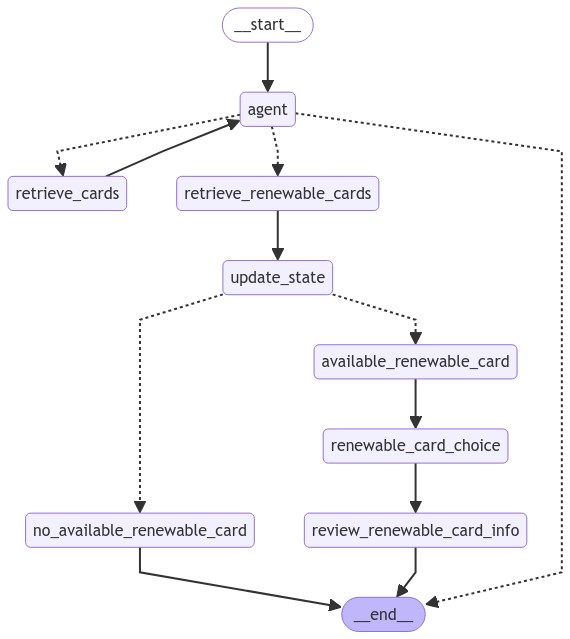

In [28]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
thread_id = str(uuid4())
config = {"configurable": {"thread_id": thread_id} | agent_configurable}

In [31]:
input_message = "how many cards do i have?"
async for event in graph.astream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

how many cards do i have?
================================== Ai Message ==================================
Tool Calls:
  retrieve_cards (call_b3xP1bf2UT2po6nipcsviX36)
 Call ID: call_b3xP1bf2UT2po6nipcsviX36
  Args:
2024-09-06 08:40:39.914 | INFO     | app.assistant.card.nodes:get_cards:46 | c3be4896-1464-400c-bd5c-55fef2069815  - Retrieve a list of cards...
2024-09-06 08:40:39.916 | DEBUG    | app.bb_retail.request:list_cards:114 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting list cards...
2024-09-06 08:40:39.916 | DEBUG    | app.bb_retail.request:_make_request:151 | c3be4896-1464-400c-bd5c-55fef2069815  - Making request to https://retail.stg.sdbxaz.azure.backbaseservices.com/api/cards-presentation-service/client-api/v2/cards...
2024-09-06 08:40:41.517 | DEBUG    | app.bb_retail.request:list_cards:119 | c3be4896-1464-400c-bd5c-55fef2069815  - Response from _make_request: [{'id': 'b465eb1e-5cba-4823-98

In [35]:
input_message = "I wanna renew my card"
async for event in graph.astream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

I wanna renew my card
================================== Ai Message ==================================
Tool Calls:
  retrieve_renewable_cards (call_OKsbbio30ckCzMskUB8NRC42)
 Call ID: call_OKsbbio30ckCzMskUB8NRC42
  Args:
    expired_days: 30
2024-09-06 08:41:22.196 | INFO     | app.assistant.card.nodes:get_cards:46 | c3be4896-1464-400c-bd5c-55fef2069815  - Retrieve a list of cards...
2024-09-06 08:41:22.198 | DEBUG    | app.bb_retail.request:list_cards:114 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting list cards...
2024-09-06 08:41:22.198 | DEBUG    | app.bb_retail.request:_make_request:151 | c3be4896-1464-400c-bd5c-55fef2069815  - Making request to https://retail.stg.sdbxaz.azure.backbaseservices.com/api/cards-presentation-service/client-api/v2/cards...
2024-09-06 08:41:23.749 | DEBUG    | app.bb_retail.request:list_cards:119 | c3be4896-1464-400c-bd5c-55fef2069815  - Response from _make_request: [{'

In [37]:
input_message = "renew the cards that will be expired in next 4 years"
async for event in graph.astream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

renew the cards that will be expired in next 4 years
================================== Ai Message ==================================
Tool Calls:
  retrieve_renewable_cards (call_b3xP1bf2UT2po6nipcsviX36)
 Call ID: call_b3xP1bf2UT2po6nipcsviX36
  Args:
    expired_days: 1460
2024-09-06 08:41:44.904 | INFO     | app.assistant.card.nodes:get_cards:46 | c3be4896-1464-400c-bd5c-55fef2069815  - Retrieve a list of cards...
2024-09-06 08:41:44.905 | DEBUG    | app.bb_retail.request:list_cards:114 | c3be4896-1464-400c-bd5c-55fef2069815  - Getting list cards...
2024-09-06 08:41:44.905 | DEBUG    | app.bb_retail.request:_make_request:151 | c3be4896-1464-400c-bd5c-55fef2069815  - Making request to https://retail.stg.sdbxaz.azure.backbaseservices.com/api/cards-presentation-service/client-api/v2/cards...
2024-09-06 08:41:46.367 | DEBUG    | app.bb_retail.request:list_cards:119 | c3be4896-1464-400c-bd5c-55fef2069815  -

In [38]:
current_state = await graph.aget_state(config=config)
nearly_last_card_id = list(current_state.values.get("cards"))[-1]
print(nearly_last_card_id)

d94b0808-f085-4ddd-be66-bd8fe67119a1


In [41]:
cards = current_state.values.get("cards")
print(cards)

{'b465eb1e-5cba-4823-981f-acb26ea3b982': Card(id='b465eb1e-5cba-4823-981f-acb26ea3b982', brand='mastercard', card_type='Debit', status='Active', lock_status='UNLOCKED', replacement_status='NotUnderReplacement', holder_name='Sara Williams', currency='USD', expiry_date='2028-08-31'),
 'd94b0808-f085-4ddd-be66-bd8fe67119a1': Card(id='d94b0808-f085-4ddd-be66-bd8fe67119a1', brand='mastercard', card_type='Debit', status='Cancelled', lock_status='UNLOCKED', replacement_status='Replaced', holder_name='Sara Williams', currency='USD', expiry_date='2028-08-31')}

In [42]:
await graph.aupdate_state(
    config=config,
    values={
        "cards": {nearly_last_card_id: cards[nearly_last_card_id]},
        "messages": HumanMessage(content=cards[nearly_last_card_id].card_type),
    },
    as_node="renewable_card_choice",
)

{'configurable': {'thread_id': '3c1f199a-2afd-4e9e-a810-b9dc3ab557bc',
  'thread_ts': '1ef6c2c1-7ee4-667f-8010-c24dca56c014'}}

In [43]:
current_state = await graph.aget_state(config=config)
print(current_state.values)

{'messages': [HumanMessage(content='how many cards do i have?', id='6207f9bb-aefd-40fc-85fc-0240a69d293d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b3xP1bf2UT2po6nipcsviX36', 'function': {'arguments': '{}', 'name': 'retrieve_cards'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 158, 'total_tokens': 165}, 'model_name': 'gpt-4-32k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-afc1e8a4-ffa4-43e4-a456-fe01eb1e2fa3-0', tool_calls=[{'name': 'retrieve_cards', 'args': {}, 'id': 'call_b3xP1bf2UT2po6nipcsviX36', 'type': 'tool_call'}], usage_metadata={'input_tokens': 158, 'output_tokens': 7, 'total_tokens': 165}),
  ToolMessage(content="[Card(id='b465eb1e-5cba-4823-981f-acb26ea3b982', brand='mastercard', card_type='Debit', status='Active', lock_status='UNLOCKED', replacement_status='NotUnderReplacement', holder_name='Sara Williams', currency=

In [39]:
current_state = await graph.aget_state(config=config)
print(current_state)

StateSnapshot(values={'messages': [HumanMessage(content="it's too hot now, what is the weather in HCMC?", id='6da8f844-188c-4e60-a435-5608fa5252af'), AIMessage(content="I'm sorry, as a banking card assistant, I can only provide help related to your cards.", response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 166, 'total_tokens': 187}, 'model_name': 'gpt-4-32k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-6f760469-af64-4726-91a0-264dd207332a-0', usage_metadata={'input_tokens': 166, 'output_tokens': 21, 'total_tokens': 187}), HumanMessage(content='how many cards do i have?', id='b7bd32a1-c333-4799-a7bd-1ef3b7ff4b17'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_psABdAxMScuhNOLOD4og8SFv', 'function': {'arguments': '{}', 'name': 'retrieve_cards'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 201, 'total_tokens': 208}, 'mod

In [40]:
print(current_state.values["responses"])

['{"thread_id":"672aa886-2db2-40ca-942d-32474e9bb5fc-available_renewable_card","response":"I found the following cards that are renewable. Which one do you want to renew?","action":"SHOW_CHOICES","metadata":{"type":"CHOICES_DATA","choices":[{"type":"CARD_CHOICE","id":"b465eb1e-5cba-4823-981f-acb26ea3b982","name":null,"description":null,"is_enabled":true,"brand":"mastercard","card_type":"Debit","status":"Active","lock_status":"UNLOCKED","replacement_status":"NotUnderReplacement","holder_name":"Sara Williams","currency":"USD","expiry_date":"2028-08-31"},{"type":"CARD_CHOICE","id":"d94b0808-f085-4ddd-be66-bd8fe67119a1","name":null,"description":null,"is_enabled":true,"brand":"mastercard","card_type":"Debit","status":"Cancelled","lock_status":"UNLOCKED","replacement_status":"Replaced","holder_name":"Sara Williams","currency":"USD","expiry_date":"2028-08-31"}]}}']

In [41]:
cards = current_state.values.get("cards")
print(cards)

{'b465eb1e-5cba-4823-981f-acb26ea3b982': Card(id='b465eb1e-5cba-4823-981f-acb26ea3b982', brand='mastercard', card_type='Debit', status='Active', lock_status='UNLOCKED', replacement_status='NotUnderReplacement', holder_name='Sara Williams', currency='USD', expiry_date='2028-08-31'),
 'd94b0808-f085-4ddd-be66-bd8fe67119a1': Card(id='d94b0808-f085-4ddd-be66-bd8fe67119a1', brand='mastercard', card_type='Debit', status='Cancelled', lock_status='UNLOCKED', replacement_status='Replaced', holder_name='Sara Williams', currency='USD', expiry_date='2028-08-31')}

In [42]:
nearly_last_card_id = list(current_state.values.get("cards"))[-1]
print(nearly_last_card_id)

d94b0808-f085-4ddd-be66-bd8fe67119a1


In [43]:
await graph.aupdate_state(
    config=config,
    values={
        "cards": {nearly_last_card_id: cards[nearly_last_card_id]},
        "messages": HumanMessage(content=cards[nearly_last_card_id].card_type),
    },
    as_node="renewable_card_choice",
)

{'configurable': {'thread_id': '672aa886-2db2-40ca-942d-32474e9bb5fc',
  'thread_ts': '1ef6c274-c219-6d17-800d-94fdbde2d536'}}

In [46]:
current_state = await graph.aget_state(config=config)
print(current_state.values)

{'messages': [HumanMessage(content="it's too hot now, what is the weather in HCMC?", id='6da8f844-188c-4e60-a435-5608fa5252af'),
  AIMessage(content="I'm sorry, as a banking card assistant, I can only provide help related to your cards.", response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 166, 'total_tokens': 187}, 'model_name': 'gpt-4-32k', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {}}, id='run-6f760469-af64-4726-91a0-264dd207332a-0', usage_metadata={'input_tokens': 166, 'output_tokens': 21, 'total_tokens': 187}),
  HumanMessage(content='how many cards do i have?', id='b7bd32a1-c333-4799-a7bd-1ef3b7ff4b17'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_psABdAxMScuhNOLOD4og8SFv', 'function': {'arguments': '{}', 'name': 'retrieve_cards'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 201, 'total_tokens': 208}, 'model_name': 'gpt-

In [44]:
# Continue the graph execution
async for event in graph.astream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

Let's review your renewable card info!


In [45]:
input_message = "it's too hot now, what is the weather in HCMC?"
async for event in graph.astream(
    {"messages": [input_message]}, config, stream_mode="values"
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

it's too hot now, what is the weather in HCMC?
================================== Ai Message ==================================

I'm sorry, but as a banking card assistant, I can only help with card-related queries. For weather updates, please refer to a reliable weather forecasting service.


In [46]:
current_state = await graph.aget_state(config=config)
print(current_state.values)

{'messages': [HumanMessage(content='how many cards do i have?', id='6207f9bb-aefd-40fc-85fc-0240a69d293d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_b3xP1bf2UT2po6nipcsviX36', 'function': {'arguments': '{}', 'name': 'retrieve_cards'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 158, 'total_tokens': 165}, 'model_name': 'gpt-4-32k', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None, 'content_filter_results': {}}, id='run-afc1e8a4-ffa4-43e4-a456-fe01eb1e2fa3-0', tool_calls=[{'name': 'retrieve_cards', 'args': {}, 'id': 'call_b3xP1bf2UT2po6nipcsviX36', 'type': 'tool_call'}], usage_metadata={'input_tokens': 158, 'output_tokens': 7, 'total_tokens': 165}),
  ToolMessage(content="[Card(id='b465eb1e-5cba-4823-981f-acb26ea3b982', brand='mastercard', card_type='Debit', status='Active', lock_status='UNLOCKED', replacement_status='NotUnderReplacement', holder_name='Sara Williams', currency=